# **Experiment: Recovering a multiresolution**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
    
SAVE_FIGURES = False

def savefig(fname, ftype):
  if SAVE_FIGURES:
    plt.savefig(f'FIG/E03_{fname:s}_{ftype:s}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'FIG/E03_{fname:s}_{ftype:s}.eps', bbox_inches='tight')

## Contents
1. [Function collection](#function-collection)
2. [Choosing a multiplier](#choosing-a-multiplier)
3. [Multiresolution](#multiresolution)

## Function collection

We show that we can recover the scaling function and the wavelet of a multiresolution from a function collection with a single element, that is, $\mathcal{F} = \{f\}$.  

In [2]:
def rect_fourier(w, xo, a):
  return a * np.exp(-1j * 2 * np.pi * w * xo) * np.sinc(a * w)

def tri_fourier(w, xo, a):
  return a * np.exp(-1j * 2 * np.pi * w * xo) * np.sinc(a * w) ** 2

Plot the possible choices of $f$ for this experiment.

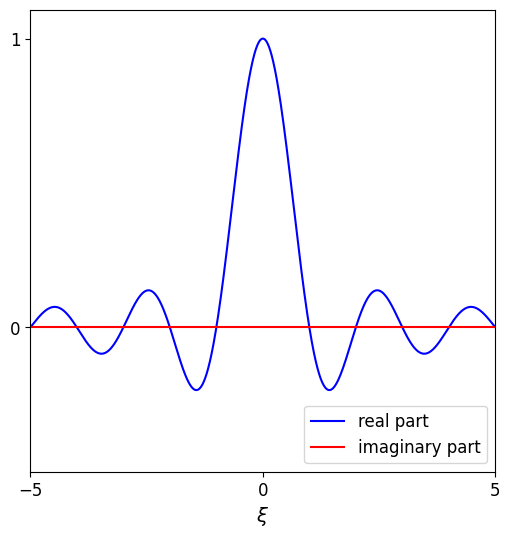

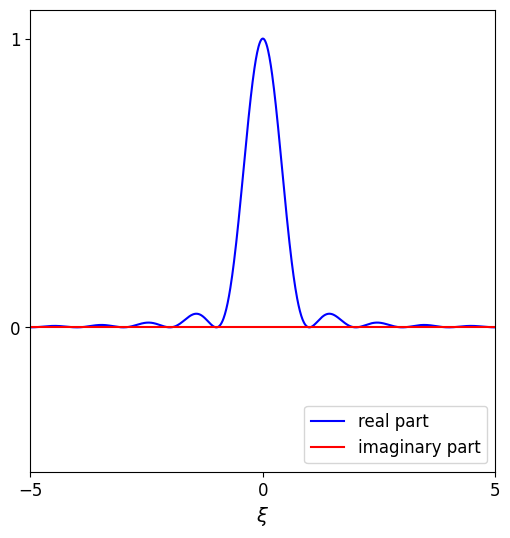

In [3]:
# frequency range
num_w = 1024
w_max = 5
w = np.linspace(-w_max, +w_max, num_w)

# plot
plt.figure(figsize=(6, 6))
plt.plot(w, rect_fourier(w, 0, 1).real, label='real part', color='b')
plt.plot(w, rect_fourier(w, 0, 1).imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
savefig('FILTER', 'SQR')
plt.legend(fontsize=12, loc='lower right')

plt.figure(figsize=(6, 6))
plt.plot(w, tri_fourier(w, 0, 1).real, label='real part', color='b')
plt.plot(w, tri_fourier(w, 0, 1).imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('FILTER', 'TRI')
plt.show()

Select the function to be used for the experiment. 

In [4]:
# - square
# ftype = 'SQR'
# fcoll = lambda w : rect_fourier(w, 0.5, 1.0)
# - triangle
ftype = 'TRI'
fcoll = lambda w : tri_fourier(w, 0.0, 1.0)

## Multiplier

Since the collection has a single element, all multipliers yield the same result. For concreteness, we use the trace multiplier. 

In [5]:
from adaptiveExtrapolationInFrequency.objects.multiplier import SMultiplier
from adaptiveExtrapolationInFrequency.objects.domain import Square1D

Select $\Omega_0 = [-1/2, 1/2]$.

In [6]:
# domain
DS = Square1D(width = 1)
# selected domain for experiments
dom_mS = DS

In [7]:
# create a multiplier for an empty collection
mS = SMultiplier(ndim = 1)
# add function
mS.append(fcoll)
# add domain
mS.domain = dom_mS

Define the $1\times 1$ identity matrix and an auxiliary handle.

In [8]:
# for 1st order window
mS.domain.delta = 5E-2
# S-matrix
S = np.eye(1)
# multiplier
mS_eval_windowed = lambda w : mS.eval_windowed(S, w)

Plot the inverse Fourier transform of the multiplier.

In [9]:
from adaptiveExtrapolationInFrequency.routines.integrals import inverse_fourier_transform_1d

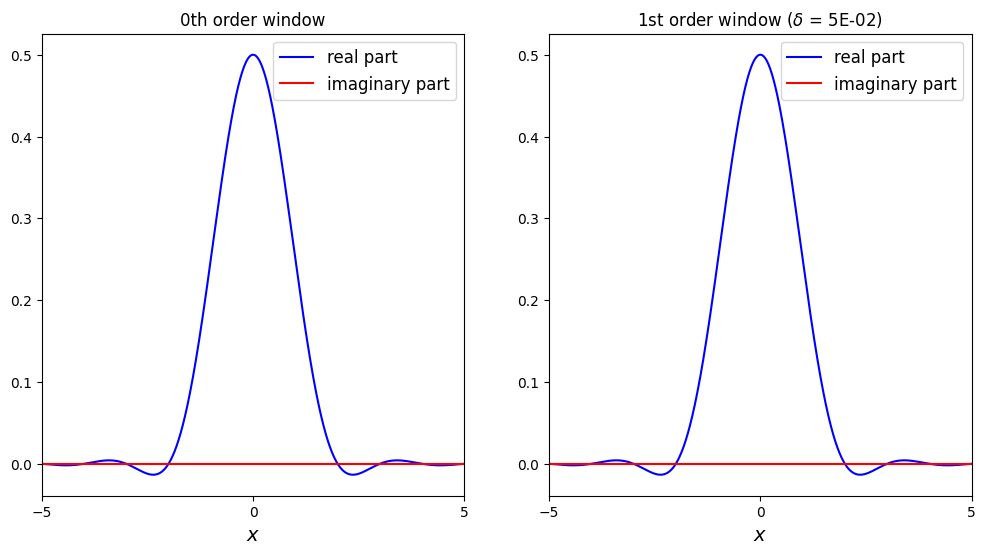

In [10]:
# spatial range
num_x = 1024
x_max = 5
x = np.linspace(-x_max, +x_max, num_x)
# 0th order
mS.domain.window = 'zeroth_order'
u_x = inverse_fourier_transform_1d(mS_eval_windowed, x, 1.0 * mS.domain.width, 2048)
# 1st order
mS.domain.window = 'first_order'
us_x = inverse_fourier_transform_1d(mS_eval_windowed, x, 1.0 * mS.domain.width, 2048)

# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, u_x.real, label='real part', color='b')
plt.plot(x, u_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, us_x.real, label='real part', color='b')
plt.plot(x, us_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, u_x.real, label='real part', color='b')
plt.plot(x, u_x.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('MTRACE', ftype)
plt.close()

## Multiresolution

Construct the functions that induce a multiresolution. For this, we import the following functions. In each case, $m$ represents the **1-periodization** of multiplier induced by the family $\mathcal{F}$. If $m_{\Sigma}$ is the multiplier induced by $\Sigma$ then
$$
  m(\xi) = m_{\Sigma}\left(\left(x+\frac{1}{2} \mod 1\right) -\frac{1}{2}\right).
$$

The functions are:
- ``phi_N`` is the approximation to a refinable function constructed using the the truncated cascade algorithm
$$\hat{\phi}_N(\xi) = \prod_{j=1}^{N} m(2^{-j}\xi) $$
- ``Phi_NK`` is the approximation to the periodization of $\widehat{\phi}_N$ with $2K + 1$ translates
$$\Phi_{N,K}(\xi) = \sum_{k = -K}^K |\widehat{\phi}_N(\xi - k)|^2 \approx \sum_{k\in \mathbb{Z}}|\widehat{\phi}_{\infty}(\xi - k)|^2$$
- ``g_NK`` is the wavelet mask given by
$$g_{N,K}(\xi) = m\left(\xi + \frac{1}{2}\right)^{*} \Phi_{N,K}\left(\xi + \frac{1}{2}\right) e^{-2\pi i \xi}$$
- ``psi_NK`` is the approximation to the associated wavelet given by
$$\widehat{\psi}_{N,K}(\xi) = g_{N,K}\left(\frac{\xi}{2}\right) \widehat{\phi}_N\left(\frac{\xi}{2}\right)$$

In [11]:
from adaptiveExtrapolationInFrequency.routines.multiresolution import phi_N, Phi_NK, g_NK, psi_NK

Plot $\widehat{\phi}_N$ and $\phi_N$.

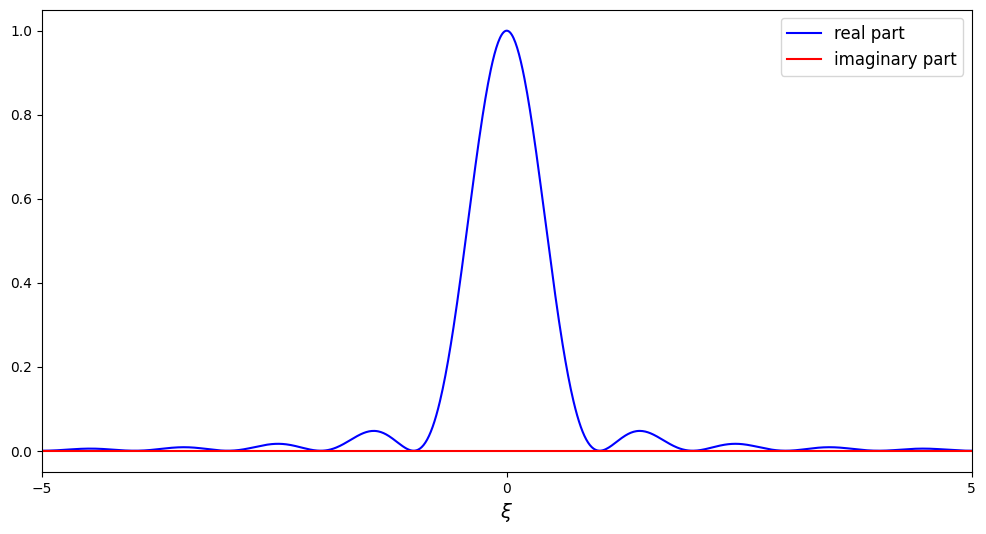

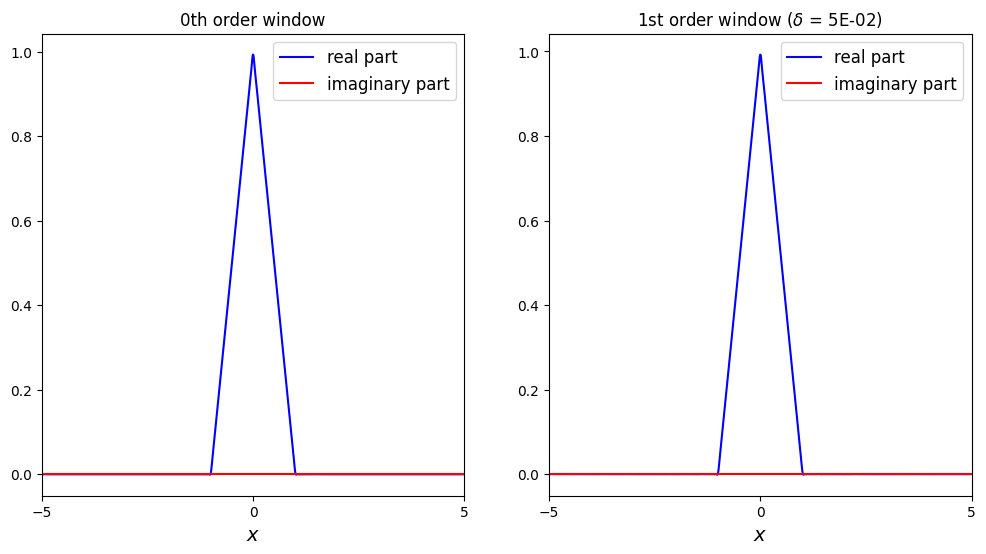

In [12]:
# spatial range
num_x = 1024
x_max = 5
x = np.linspace(-x_max, +x_max, num_x)
# 0th order window
mS.domain.window = 'zeroth_order'
phi_N_hat_w = phi_N(mS_eval_windowed, N=64)(w)
phi_N_x = inverse_fourier_transform_1d(phi_N(mS_eval_windowed, N=64), x,  2**4 * mS.domain.width, 2048)
# 1st order window
mS.domain.window = 'first_order'
phis_N_x = inverse_fourier_transform_1d(phi_N(mS_eval_windowed, N=64), x, 2**4 * mS.domain.width, 2048)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(w, phi_N_hat_w.real, label='real part', color='b')
plt.plot(w, phi_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.show()

# plot space domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, phi_N_x.real, label='real part', color='b')
plt.plot(x, phi_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, phis_N_x.real, label='real part', color='b')
plt.plot(x, phis_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, mS.eval_function(w)[0].real, color='b', linestyle=':')
plt.plot(w, mS.eval_function(w)[0].imag, color='r', linestyle=':')
plt.plot(w, phi_N_hat_w.real, label='real part', color='b')
plt.plot(w, phi_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PHI_N_HAT', ftype)
plt.close()

plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, phi_N_x.real, label='real part', color='b')
plt.plot(x, phi_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PHI_N', ftype)
plt.close()


Plot the periodization $\Phi_{N,K}$.

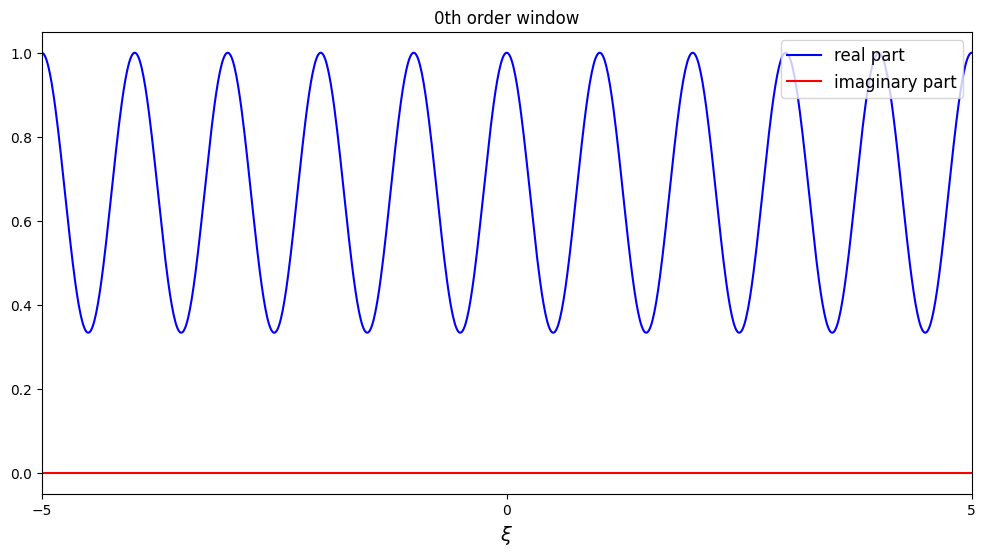

In [13]:
# 0th order window
mS.domain.window = 'zeroth_order'
Phi_NK_w = Phi_NK(w, mS_eval_windowed, N=64, K=128)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(x, Phi_NK_w.real, label='real part', color='b')
plt.plot(x, Phi_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, Phi_NK_w.real, label='real part', color='b')
plt.plot(w, Phi_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PPHI_NK_HAT', ftype)
plt.close()

Plot the wavelet mask $g_{N,K}$.

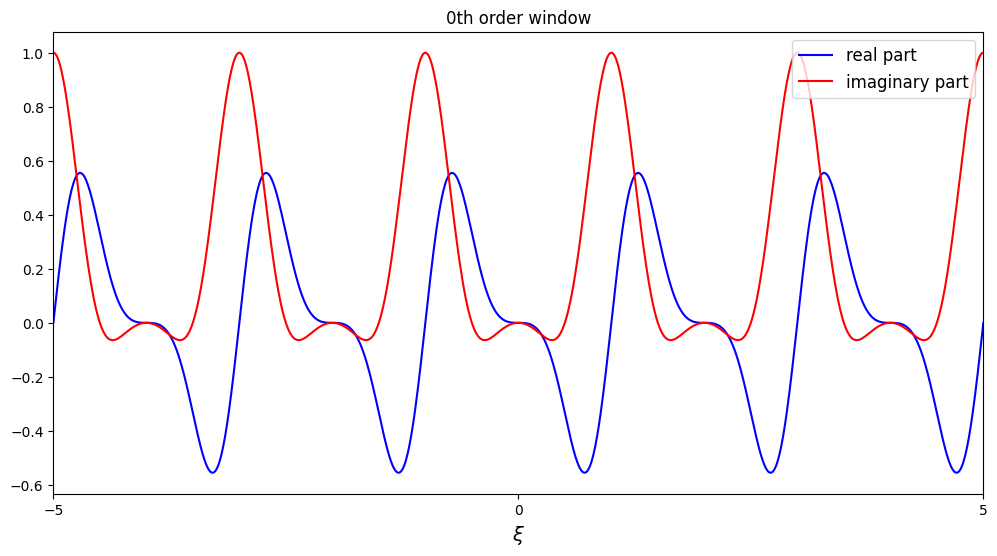

In [14]:
# 0th order window
mS.domain.window = 'zeroth_order'
g_NK_w = g_NK(0.5*w, mS_eval_windowed, N=64, K=128)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(w, g_NK_w.real, label='real part', color='b')
plt.plot(w, g_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, g_NK_w.real, label='real part', color='b')
plt.plot(w, g_NK_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -1.1, +0.5 ])
plt.yticks([ -1, 0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
savefig('G_NK_HAT', ftype)
plt.close()

Finally, plot $\widehat{\psi}_{N,K}$ and $\psi_{N,K}$.

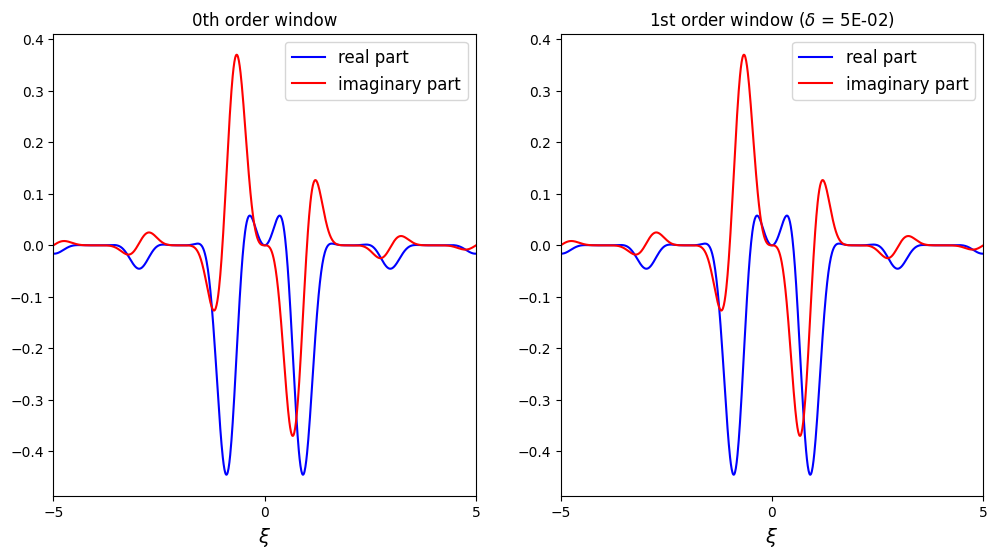

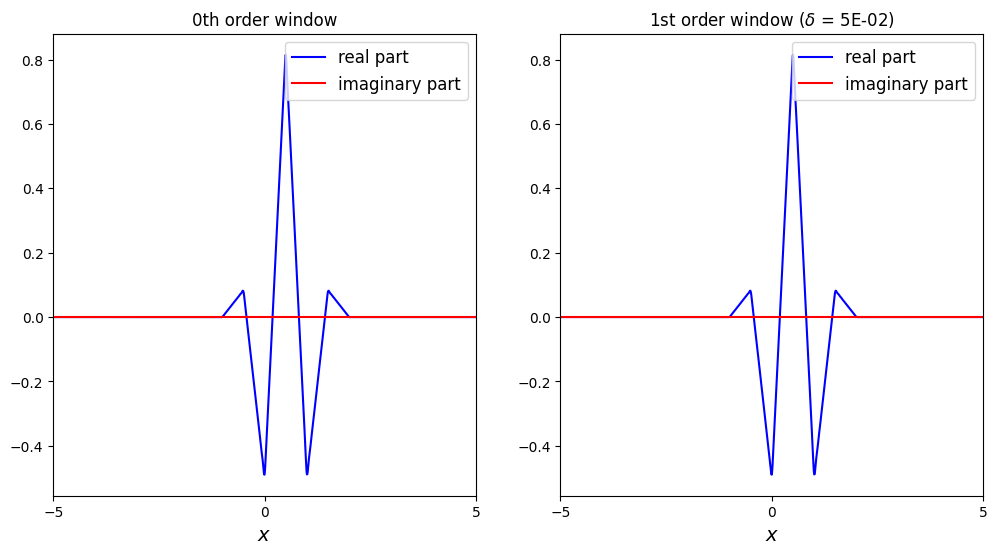

In [15]:
# phase
psi_ph = 1j
# 0th order
mS.domain.window = 'zeroth_order'
psi_NK_hat_w = psi_NK(mS_eval_windowed, psi_0=psi_ph, N=64, K=128)(w)
psi_NK_x = inverse_fourier_transform_1d(psi_NK(mS_eval_windowed, psi_0=psi_ph, N=64, K=128), x,  2**4 * mS.domain.width, 2048)
# 1st order
mS.domain.window = 'first_order'
psis_N_hat_w = psi_NK(mS_eval_windowed, psi_0=psi_ph, N=64, K=128)(x)
psis_N_x = inverse_fourier_transform_1d(psi_NK(mS_eval_windowed, psi_0=psi_ph, N=64, K=128), x, 2**4 * mS.domain.width, 2048)

# plot frequency domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(w, psi_NK_hat_w.real, label='real part', color='b')
plt.plot(w, psi_NK_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(w, psis_N_hat_w.real, label='real part', color='b')
plt.plot(w, psis_N_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# plot space domain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, psi_NK_x.real, label='real part', color='b')
plt.plot(x, psi_NK_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title('0th order window')
plt.subplot(1, 2, 2)
plt.plot(x, psis_N_x.real, label='real part', color='b')
plt.plot(x, psis_N_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ])
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.title(f'1st order window ($\\delta$ = {mS.domain.delta:.0E})')
plt.show()

# figures for paper ------------------------------------------------------------------------------------------
plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(w, psi_NK_hat_w.real, label='real part', color='b')
plt.plot(w, psi_NK_hat_w.imag, label='imaginary part', color='r')
plt.xlim([ w.min(), w.max() ])
plt.xticks([ w.min(), 0, w.max() ], fontsize=12)
plt.ylim([ -0.5, +1.1 ])
plt.yticks([ 0.0, 1.0 ], fontsize=12)
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PSI_NK_HAT', ftype)
plt.close()

plt.ioff()
plt.figure(figsize=(6, 6))
plt.plot(x, psi_NK_x.real, label='real part', color='b')
plt.plot(x, psi_NK_x.imag, label='imaginary part', color='r')
plt.xlim([ x.min(), x.max() ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=12)
plt.ylim([ -1.1, +1.1 ])
plt.yticks([ -1.0, 0.0, 1.0 ], fontsize=12)
plt.xlabel('$x$', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
savefig('PSI_NK', ftype)
plt.close()